In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd 
import requests
import json
import contextily as cx
import textwrap


In [3]:

top_stations = pd.read_csv('202304-divvy-tripdata.csv', usecols=['start_station_name', 'start_lat', 'start_lng', 'member_casual'])
top_stations.rename(columns={'start_station_name': 'name', 'start_lat': 'lat', 'start_lng': 'lon'}, inplace=True)
top_stations.head(10)


,name,lat,lon,member_casual
0,NaN,41.80,-87.60,member
1,NaN,41.87,-87.65,member
2,NaN,41.93,-87.66,member
3,NaN,41.92,-87.65,member
4,NaN,41.91,-87.65,member
5,NaN,41.91,-87.63,member
6,NaN,41.93,-87.66,member
7,NaN,42.00,-87.66,member
8,NaN,41.99,-87.66,member
9,NaN,41.88,-87.65,member


In [6]:
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362776 entries, 28 to 426589
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           362776 non-null  object 
 1   lat            362776 non-null  float64
 2   lon            362776 non-null  float64
 3   member_casual  362776 non-null  object 
dtypes: float64(2), object(2)
memory usage: 13.8+ MB


In [5]:
top_stations.dropna(subset=['name', 'lat', 'lon'], inplace=True)


In [7]:
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362776 entries, 28 to 426589
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           362776 non-null  object 
 1   lat            362776 non-null  float64
 2   lon            362776 non-null  float64
 3   member_casual  362776 non-null  object 
dtypes: float64(2), object(2)
memory usage: 13.8+ MB


In [8]:
# group by station and check for unique coordinates
groupy = top_stations.groupby('name')[['lat', 'lon']].nunique()
groupy.sort_values(by='lat', ascending=False).head(10)


,lat,lon
name,,
Clinton St & Washington Blvd,1254,1230
Streeter Dr & Grand Ave,1208,1444
Wells St & Concord Ln,1155,1191
Clark St & Elm St,1112,1147
Kingsbury St & Kinzie St,1011,1162
Wells St & Elm St,1003,1017
Clinton St & Madison St,999,1045
Sheffield Ave & Waveland Ave,950,927
LaSalle St & Illinois St,917,888


In [9]:
# find top 10 stations by count
top_group = top_stations.groupby('name')['name'].agg(Count='count').sort_values(by='Count', ascending=False).head(10).reset_index()
top_group

,name,Count
0,Streeter Dr & Grand Ave,4721
1,University Ave & 57th St,3064
2,DuSable Lake Shore Dr & Monroe St,3022
3,Ellis Ave & 60th St,2915
4,Kingsbury St & Kinzie St,2765
5,Clark St & Elm St,2634
6,Michigan Ave & Oak St,2535
7,Wells St & Concord Ln,2512
8,Clinton St & Washington Blvd,2437
9,Theater on the Lake,2254


In [10]:

# Obtain station data from Divvy API
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
bike = requests.get('https://gbfs.divvybikes.com/gbfs/en/station_information.json')
bike_json = bike.json()
bike_data = bike_json['data']['stations']
station = pd.DataFrame(bike_data)

# create dataframe with station name and coordinates
stations = station[['name', 'lat', 'lon']]
stations.head(10)

,name,lat,lon
0,Clark St & Touhy Ave,42.012560,-87.674367
1,Blue Island Ave & 18th St,41.857556,-87.661535
2,Kedzie Ave & 24th St,41.848193,-87.705412
3,Damen Ave & 51st St,41.800908,-87.674684
4,Hoyne Ave & Balmoral Ave,41.979851,-87.681932
5,Sheridan Rd & Lawrence Ave,41.969517,-87.654691
6,Ashland Ave & 63rd St,41.779374,-87.664843
7,Ashland Ave & Grand Ave,41.891072,-87.666611
8,Dayton St & North Ave,41.910578,-87.649422
9,Damen Ave & Madison St,41.881370,-87.674930


In [11]:
# join top 10 stations dataframe with coordinate data from API
top_station = top_group.merge(stations, on='name', how='left')
top_station.head(10)

,name,Count,lat,lon
0,Streeter Dr & Grand Ave,4721,41.892278,-87.612043
1,University Ave & 57th St,3064,41.791478,-87.599861
2,DuSable Lake Shore Dr & Monroe St,3022,41.880958,-87.616743
3,Ellis Ave & 60th St,2915,41.785097,-87.601073
4,Kingsbury St & Kinzie St,2765,41.889177,-87.638506
5,Clark St & Elm St,2634,41.902973,-87.631280
6,Michigan Ave & Oak St,2535,41.900960,-87.623777
7,Wells St & Concord Ln,2512,41.912133,-87.634656
8,Clinton St & Washington Blvd,2437,41.883380,-87.641170
9,Theater on the Lake,2254,41.926277,-87.630834


In [12]:
# create geodataframe from new top station dataframe
gdf = gpd.GeoDataFrame(top_station, geometry=gpd.points_from_xy(top_station.lon, top_station.lat), crs="EPSG:4326")
gdf.head(5)


,name,Count,lat,lon,geometry
0,Streeter Dr & Grand Ave,4721,41.892278,-87.612043,POINT (-87.61204 41.89228)
1,University Ave & 57th St,3064,41.791478,-87.599861,POINT (-87.59986 41.79148)
2,DuSable Lake Shore Dr & Monroe St,3022,41.880958,-87.616743,POINT (-87.61674 41.88096)
3,Ellis Ave & 60th St,2915,41.785097,-87.601073,POINT (-87.60107 41.78510)
4,Kingsbury St & Kinzie St,2765,41.889177,-87.638506,POINT (-87.63851 41.88918)


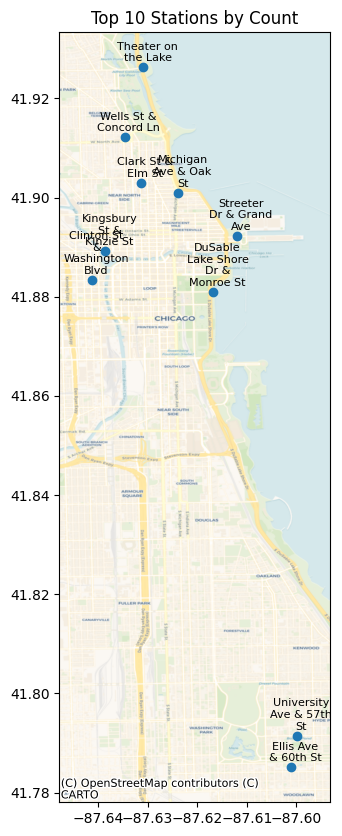

In [13]:
# plot top 10 stations on map
ax = gdf.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)
plt.title('Top 10 Stations by Count')
plt.show()

In [14]:
top_stations

,name,lat,lon,member_casual
28,Kenosha & Wellington,41.930000,-87.730000,member
123,California Ave & Division St,41.903010,-87.697637,member
227,Avenue O & 134th St,41.651868,-87.539671,member
249,California Ave & Milwaukee Ave,41.922660,-87.697057,member
288,Campbell Ave & Montrose Ave,41.961605,-87.691177,member
...,...,...,...,...
426585,Halsted St & 18th St,41.857506,-87.645991,casual
426586,Halsted St & 18th St,41.857506,-87.645991,casual
426587,Franklin St & Jackson Blvd,41.877708,-87.635321,casual
426588,Michigan Ave & Lake St,41.886022,-87.624398,casual


In [15]:
# top 10 stations
x = top_stations.groupby('name').size().sort_values(ascending=False).head(10)
x

name
Streeter Dr & Grand Ave              4721
University Ave & 57th St             3064
DuSable Lake Shore Dr & Monroe St    3022
Ellis Ave & 60th St                  2915
Kingsbury St & Kinzie St             2765
Clark St & Elm St                    2634
Michigan Ave & Oak St                2535
Wells St & Concord Ln                2512
Clinton St & Washington Blvd         2437
Theater on the Lake                  2254
dtype: int64

In [16]:
ab = []
for l in x.index:
    ab.append(l)
    
print(ab)

['Streeter Dr & Grand Ave', 'University Ave & 57th St', 'DuSable Lake Shore Dr & Monroe St', 'Ellis Ave & 60th St', 'Kingsbury St & Kinzie St', 'Clark St & Elm St', 'Michigan Ave & Oak St', 'Wells St & Concord Ln', 'Clinton St & Washington Blvd', 'Theater on the Lake']


In [17]:
# filter out non top 10 stations
plot_data = top_stations[top_stations['name'].isin(ab)]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



# Define the color palettes you want to use
custom_palette2 = ['#FFC300', '#DAF7A6', '#FF5733', '#C70039']
palettes = ['Paired']

# Create subplots for each color palette
fig, axes = plt.subplots(1, len(palettes), figsize=(18, 8), sharey=True)

# Iterate over each palette and create a barplot
for i, palette in enumerate(palettes):
    # Set the color palette for the current subplot
    sns.set_palette(palette)
    
    # Create the barplot
    sns.countplot(x=plot_data['name'], hue=plot_data['member_casual'], ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(f'Palette: {palette}')
    axes[i].set_xticklabels([])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


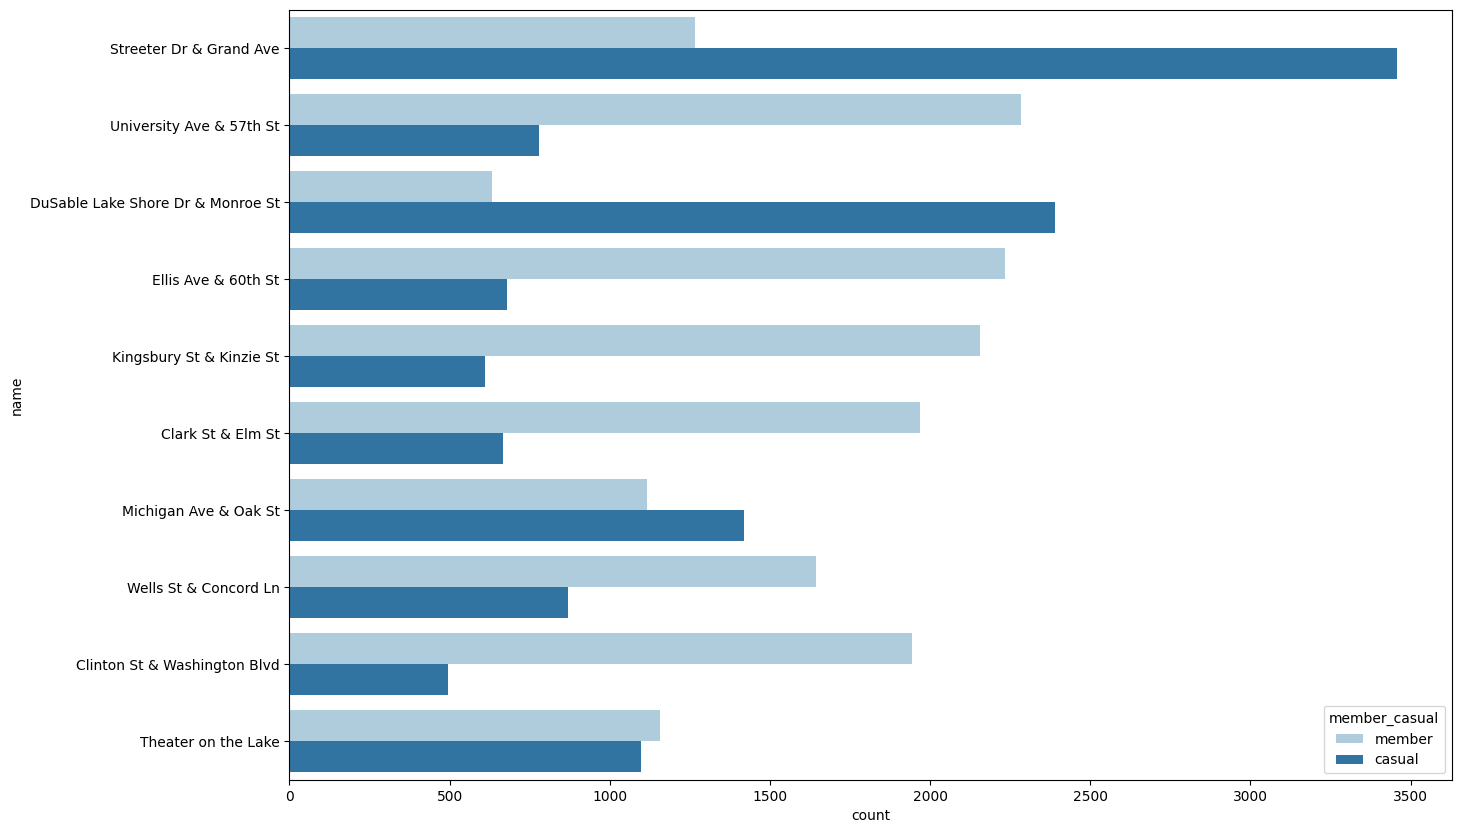

In [18]:

plt.figure(figsize=(15, 10))
sns.countplot(data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')
plt.show()

In [98]:
x = top_stations.groupby('name')['member_casual'].size().sort_values(ascending=False).head(10)


name
Streeter Dr & Grand Ave               15756
DuSable Lake Shore Dr & Monroe St      8652
Michigan Ave & Oak St                  8333
DuSable Lake Shore Dr & North Blvd     8281
Wells St & Concord Ln                  7796
Clark St & Elm St                      7363
Millennium Park                        7336
Kingsbury St & Kinzie St               7295
Theater on the Lake                    6966
Wells St & Elm St                      6578
Name: member_casual, dtype: int64


In [66]:
df1 = top_stations.groupby(['name', 'member_casual']).size()
#df2 = df1.sort_values(by='count', ascending=False)
#df3 = df2.groupby('name').head(2)
df1


name                          member_casual
111th St - Morgan Park Metra  casual             1
                              member             1
2112 W Peterson Ave           casual            71
                              member           109
410                           casual             1
                                              ... 
Yates Blvd & 75th St          casual            33
                              member            16
Yates Blvd & 93rd St          casual            10
                              member            13
Yates Blvd & Exchange Ave     casual             3
Length: 2417, dtype: int64

In [38]:
top_members = top_stations.groupby(['name', 'member_casual'])['member_casual'].agg(count='count').sort_values(by='count', ascending=False).reset_index().head(10)
top_members

,name,member_casual,count
0,Streeter Dr & Grand Ave,casual,12019
1,DuSable Lake Shore Dr & Monroe St,casual,6682
2,Millennium Park,casual,5370
3,Kingsbury St & Kinzie St,member,5343
4,Michigan Ave & Oak St,casual,5284
5,DuSable Lake Shore Dr & North Blvd,casual,4846
6,Clark St & Elm St,member,4748
7,Clinton St & Washington Blvd,member,4491
8,Wells St & Concord Ln,member,4460
9,Shedd Aquarium,casual,4378


In [ ]:
sns.barplot(data=top_stations, x)

In [ ]:
for i, r in gdf.iterrows():
    ax.annotate(r['name'], xy=(r.geometry.x, r.geometry.y))

In [ ]:
ax2.table(cellText=df[['Station Name', 'Count']].values, colLabels=['Station Name', 'Count'], loc='center')


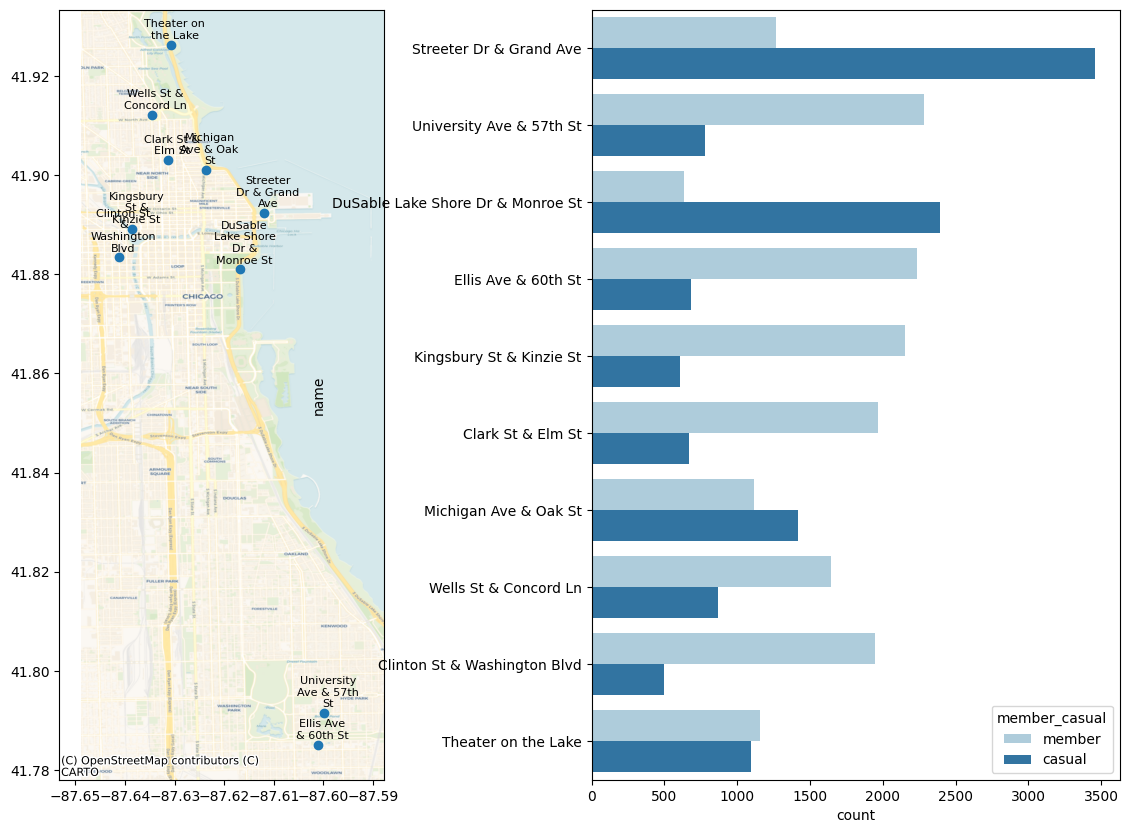

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax1 = gdf.plot(ax=axes[0])
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax1.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)


sns.countplot(ax=axes[1], data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')


plt.show()

# one map, one side by side bar plot

In [ ]:
chicago = gpd.read_file(gds.get_path('geoda.chicago_health'))
chicago.head(5)

In [30]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [40]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [ ]:
chicago.centroid.explore()

In [37]:
ax = chicago.centroid.explore()
cx.add_basemap(ax, crs=chicago.crs.to_string())

C:\Users\Andy\AppData\Local\Temp\ipykernel_22432\1963832225.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = chicago.centroid.explore()


AttributeError: 'Map' object has no attribute 'axis'

In [ ]:
station_list.drop(['electric_bike_surcharge_waiver', 'has_kiosk', 'rental_uris', 'eightd_has_key_dispenser', 'eightd_station_services', 'target_bike_capacity', 'target_scooter_capacity', 'region_id', 'region_code', 'client_station_id', 'rack_model'], axis=1, inplace=True)